### <span style="font-size: 28px; font-weight: bold;">Data Science Project: Planning Stage</span>

## (1) Data Description

The dataset used in this project is `players.csv`, which includes player-level information collected from a Minecraft research server. Each row represents a unique player and contains demographic details, gameplay behavior, and a binary indicator of whether or not the player subscribed to a game-related newsletter.

### Dataset Summary
- Number of observations: 196 players.
- Number of variables: 7 columns.
- Target variable: `subscribe` (TRUE/FALSE).

### Variables Overview

| Variable Name  | Type        | Description |
|----------------|-------------|-------------|
| `experience`   | Categorical | Level of gaming experience (e.g., Amateur, Veteran, Pro). |
| `subscribe`    | Logical     | Whether or not the player is subscribed to the newsletter (TRUE/FALSE). |
| `hashedEmail`  | String      | Each player's unique identifier. |
| `played_hours` | Numeric     | Total number of hours the player spent on the server. |
| `name`         | String      | Player's first name. |
| `gender`       | Categorical | Player's gender (e.g., Male, Female). |
| `Age`          | Numeric     | Player's age in years. |

### Summary Statistics
- Mean Age: 21.14 years  
- Mean Played Hours: 5.85 hours

### Observed Issues
- Some players show "0" for `played_hours`, which may suggest they registered but never actually played.
- The `name` and `hashedEmail` columns are irrelevant to the model.
- Relatively small dataset (n = 196), which makes it prone to overfitting.
- Ordinal categorical variables such as `experience` will be handled as nominal unless reclassified.

### Potential Hidden Issues
- Class imbalance: If the proportions of subscribed and non-subscribed users are uneven, it may negatively impact classifier performance.
- Possibility of underlying bias in self-reported variables (e.g., `experience`).
- Missing values aren’t immediately obvious, but they should be verified and properly handled before modeling.
- No missing values were found in the dataset. If any had been present, imputation would have been applied depending on the variable type and context.

### Data Collection Context
This data was collected by a UBC Computer Science research team running a public Minecraft server. The goal of the research is to understand player behavior and engagement, and support recruitment and infrastructure decisions.

## (2) Question of Interest

My question of interest is: **"Can a player’s experience level, gender, age, and hours played predict whether they subscribe to the game-related newsletter?"**


To apply predictive methods, I will:
- Encode the categorical variables (`experience`, `gender`) using dummy variables.
- Ensure that the response variable (`subscribe`) is properly formatted as a factor.
- Split the data into training and testing sets, and apply 5-fold cross-validation during model evaluation.

This wrangling will prepare the dataset for logistic regression.

## (3) Exploratory Data Analysis & Visualization

In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
players <- read_csv("players.csv")
head(players)
glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


In [4]:
players %>%
  summarise(mean_age = round(mean(Age, na.rm = TRUE), 2),
            mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2))

mean_age,mean_played_hours
<dbl>,<dbl>
21.14,5.85


In [5]:
players %>%
  summarise_all(~ sum(is.na(.)))

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,2


### Plot 1: Played Hours by Subscription

This plot shows that players who subscribed to the newsletter tend to have played more hours. Players with few or zero hours of gameplay were much less likely to subscribe.

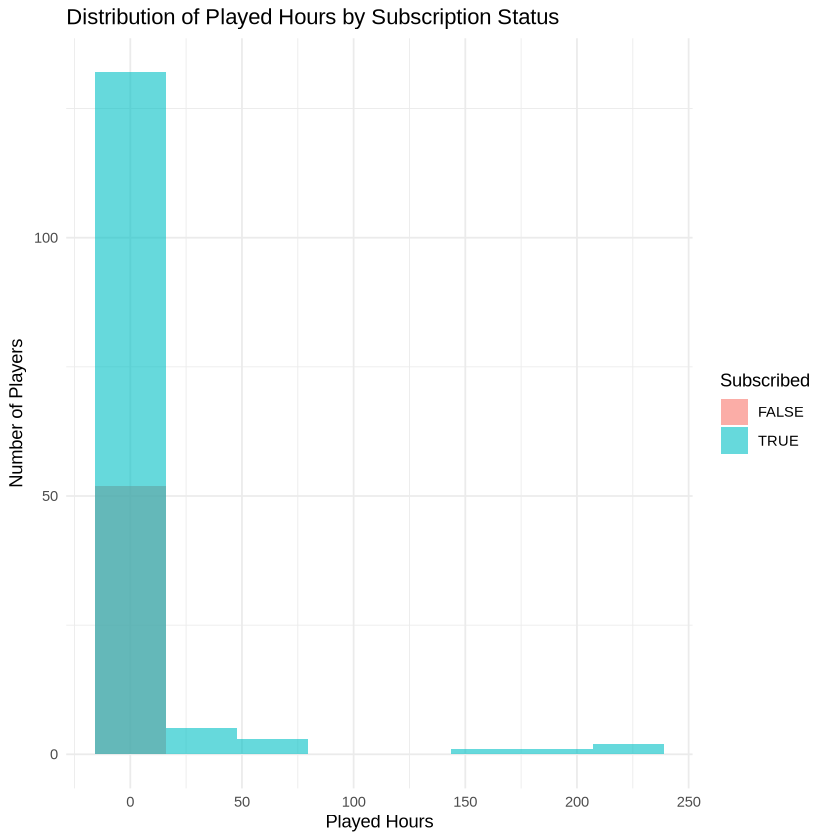

In [9]:
ggplot(players, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "identity", alpha = 0.6, bins = 8) +
  labs(
    title = "Distribution of Played Hours by Subscription Status",
    x = "Played Hours",
    y = "Number of Players",
    fill = "Subscribed"
  ) +
  theme_minimal()

### Plot 2: Subscription Rate by Experience Level

More experienced players (e.g., Pro, Veteran) had higher subscription rates.  
This suggests experience level could be a useful predictor in a classification model.

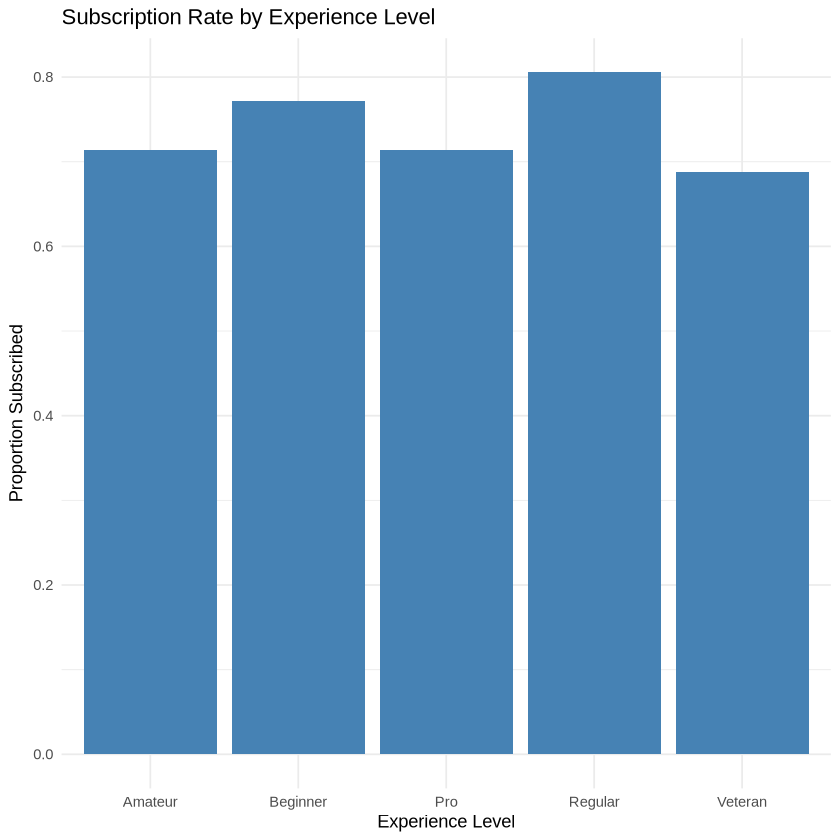

In [10]:
players %>%
  group_by(experience) %>%
  summarise(subscription_rate = mean(subscribe == TRUE)) %>%
  ggplot(aes(x = experience, y = subscription_rate)) +
  geom_col(fill = "steelblue") +
  labs(
    title = "Subscription Rate by Experience Level",
    x = "Experience Level",
    y = "Proportion Subscribed"
  ) +
  theme_minimal()

## (4) Methods and Plan

To address our question: *"Can a player’s experience level, gender, age, and hours played predict whether they subscribe to the game-related newsletter?"*, our choice of modelling will be the use of a logistic regression.

### Why Logistic Regression?
- The outcome variable (`subscribe`) is binary (TRUE/FALSE).
- For binary classification tasks, logistic regression provides both effectiveness and ease of interpretation.
- Has the capability of handling both categorical (e.g., `experience`, `gender`) and numeric (e.g., `Age`, `played_hours`) predictors.

### Underlying Assumptions
- The outcome's log-odds can be expressed as a linear combination of the predictors.
- The data should consist of independent observations from a representative population sample.
- The predictors are independent (no multicollinearity and uncorrelated).

### Potential Limitations or Weaknesses
- May struggle with capturing more complex or non-linear relationships.
- Somewhat vulnerable to imbalanced classes (in this case a disproportionate numbers of subscribers vs. non-subscribers can negatively impact results).
- Categorical variables require careful preprocessing through techniques such as using one-hot encoding.

### Model Comparison and Selection
To compare and select the most appropriate model for predicting newsletter subscription, it makes the most sense to use a combination of train/test splitting, cross-validation, and add multiple evaluation metrics. Although the final project might involve trying multiple models (e.g., logistic regression, decision trees, or random forests), in this planning stage I will focus on logistic regression as the primary candidate.

### Data Preprocessing Plan
To ensure that the model is trained on reliable, quality, and well-structured data, the following steps will be taken to ensure the reproducibility of the final results:
- Clean the data.
- Split into training and testing dataset.
- Cross-validate.
- Convert categorical variables into dummy variables.
- Scale numeric variables.
- Train final model on the entire training dataset.